In [3]:
import numpy as np 
import pandas as pd 
import torch
from string import punctuation
from stop_words import get_stop_words
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
import matplotlib.pyplot as plt

In [7]:
from pymorphy2 import MorphAnalyzer

# variables
max_words = 3000
max_len = 20
num_classes = 1

# Training
epochs = 32
batch_size = 128
print_batch_n = 100

In [8]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()

,class,tweet
0,1,"[9-1-13] 2:50 pm ""son of a bitch ate my mac n ..."
1,1,RT @BryceSerna: Don't be a pussy grab the boot...
2,2,RT @ClicquotSuave: bunch of rappers boutta flo...
3,2,@michigannews13 wow. Thats great language comi...
4,1,"and this is why I'm single, I don't fuck with ..."


In [9]:
train_df['class'].value_counts()

# 0: Hateful
# 1: Offensive
# 2: Clean

1    11491
2     2515
0      863
Name: class, dtype: int64

In [10]:
sw = set(get_stop_words("en"))
sw.add('user')
puncts = set(punctuation)

In [11]:
morpher = MorphAnalyzer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("not\s", "no", txt)
#   txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    txt = [lemmatizer.lemmatize(word) for word in txt.split() if word not in sw]
    return " ".join(txt)

train_df['tweet'].iloc[:1].values

array(['[9-1-13] 2:50 pm "son of a bitch ate my mac n cheese" http://t.co/My5oJYZ8w9'],
      dtype=object)

In [12]:
train_df['tweet'].iloc[:1].apply(preprocess_text).values

array(['9113 250 pm son bitch ate mac n cheese httptcomy5ojyz8w9'],
      dtype=object)

In [13]:
from tqdm import tqdm 
tqdm.pandas()

train_df['tweet'] = train_df['tweet'].progress_apply(preprocess_text)
test_df['tweet'] = test_df['tweet'].progress_apply(preprocess_text)

100%|██████████| 9914/9914 [00:00<00:00, 21516.35it/s]


In [14]:
train_corpus = " ".join(train_df["tweet"])
train_corpus = train_corpus.lower()

In [15]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


['9113', '250', 'pm', 'son', 'bitch']

In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [17]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

2999

In [18]:
tokens_filtered_top[:10]

['bitch', 'rt', 'hoe', 'like', 'pussy', 'nigga', 'im', 'dont', 'got', 'as']

In [19]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
len(vocabulary)

2999

In [20]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [21]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in test_df["tweet"]])

Wall time: 2.24 s


In [22]:
x_train.shape

(14869, 20)

In [23]:
x_train[0]

array([ 280,    1,  543, 1991,  111,  884,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

In [24]:
train_df['tweet'][0]

'9113 250 pm son bitch ate mac n cheese httptcomy5ojyz8w9'

In [25]:
train_df['class'][0]

1

In [26]:
def weighted_binary_cross_entropy(output, target, weights=(0.075, 1)):
        
    if weights is not None:
        assert len(weights) == 2
        
        loss = weights[1] * (target * torch.log(output)) + \
               weights[0] * ((1 - target) * torch.log(1 - output + np.finfo(float).eps))
    else:
        loss = target * torch.log(output) + (1 - target) * torch.log(1 - output)

    return torch.neg(torch.mean(loss))

In [45]:
def my_train(model, th=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    th = 0.5

    train_loss_history = []
    test_loss_history = []


    for epoch in range(epochs):  
        running_items, running_right,  train_target_true, train_target_pred = 0.0, 0.0, 0.0, 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            # обнуляем градиент
            optimizer.zero_grad()
            outputs = model(inputs)

            loss = weighted_binary_cross_entropy(outputs, labels.float().view(-1, 1), (0.075, 1))
            loss.backward()
            optimizer.step()

            # подсчет ошибки на обучении
            loss = loss.item()
            running_items += len(labels)
            # подсчет метрики на обучении
            pred_labels = torch.squeeze((outputs > th).int())
            running_right += (labels == pred_labels).sum()
            
            train_target_true += torch.sum(labels == 1).float()
            train_target_pred += ((labels == 1) & (pred_labels==1)).sum()

        # выводим статистику о процессе обучения
        model.eval()

        print(f'Epoch [{epoch + 1}/{epochs}]. ' \
                f'Step [{i + 1}/{len(train_loader)}]. ' \
                f'Loss: {loss:.3f}. ' \
                f'Recall: {train_target_pred/train_target_true:.3f}. ' \
                f'Acc: {running_right / running_items:.3f}', end='. ')
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        train_loss_history.append(loss)

            # выводим статистику на тестовых данных
        test_running_right, test_running_total, test_loss,  = 0.0, 0.0, 0.0, 
        target_true, target_pred, train_target_true, train_target_pred = 0.0, 0.0, 0.0, 0.0
        for j, data in enumerate(val_loader):

            test_labels = data[1].to(device)
            test_outputs = model(data[0].to(device))

            target_true += torch.sum(test_labels == 1).float()


            # подсчет ошибки на тесте
            test_loss = weighted_binary_cross_entropy(test_outputs, test_labels.float().view(-1, 1), (0.075, 1))
            # подсчет метрики на тесте
            test_running_total += len(data[1])
            pred_test_labels = torch.squeeze((test_outputs > th).int())
            target_pred += ((test_labels==1) & (pred_test_labels==1)).sum()
            test_running_right += (test_labels == pred_test_labels).sum()

        test_loss_history.append(test_loss.item())
        print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}. Test recall {target_pred/target_true:.3f}')
#         target_true, target_pred, test_running_right = 0.0, 0.0, 0.0
        model.train()

    print('Training is finished!')


    plt.title('Loss history')
    plt.grid(True)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(train_loss_history, label='train')
    plt.plot(test_loss_history, label='test')
    plt.legend();

In [28]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = F.sigmoid(output)
        return output

In [29]:
class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)
       
        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [30]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)
       
        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)
    
        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [31]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, train_df['class'], train_size=0.75, random_state=3)


train_dataset = DataWrapper(X_train, Y_train.values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)




val_dataset = DataWrapper(X_test, Y_test.values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [34]:
Y_train.value_counts(normalize=True)

1    0.773563
2    0.168595
0    0.057842
Name: class, dtype: float64

In [35]:
Y_test.value_counts(normalize=True)

1    0.770576
2    0.170791
0    0.058634
Name: class, dtype: float64

In [36]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([128, 20])
torch.Size([128])
tensor(1)


In [38]:
gru_model = GRUFixedLen(vocab_size=max_words)

In [39]:
lstm_model = LSTMFixedLen(vocab_size=max_words)

In [41]:
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.0001)

Epoch [1/32]. Step [88/88]. Loss: 0.029. Recall: 1.000. Acc: 0.774. Test loss: -0.018. Test acc: 0.770. Test recall 1.000
Epoch [2/32]. Step [88/88]. Loss: -0.189. Recall: 1.000. Acc: 0.774. Test loss: -0.078. Test acc: 0.770. Test recall 1.000
Epoch [3/32]. Step [88/88]. Loss: -0.070. Recall: 1.000. Acc: 0.774. Test loss: -0.087. Test acc: 0.770. Test recall 1.000
Epoch [4/32]. Step [88/88]. Loss: -0.038. Recall: 1.000. Acc: 0.774. Test loss: 0.096. Test acc: 0.770. Test recall 1.000
Epoch [5/32]. Step [88/88]. Loss: -0.123. Recall: 1.000. Acc: 0.774. Test loss: 0.103. Test acc: 0.770. Test recall 1.000
Epoch [6/32]. Step [88/88]. Loss: -0.132. Recall: 1.000. Acc: 0.774. Test loss: 0.000. Test acc: 0.770. Test recall 1.000
Epoch [7/32]. Step [88/88]. Loss: -0.047. Recall: 1.000. Acc: 0.774. Test loss: 0.000. Test acc: 0.770. Test recall 1.000
Epoch [8/32]. Step [88/88]. Loss: -0.101. Recall: 1.000. Acc: 0.774. Test loss: -0.126. Test acc: 0.770. Test recall 1.000
Epoch [9/32]. Step [8

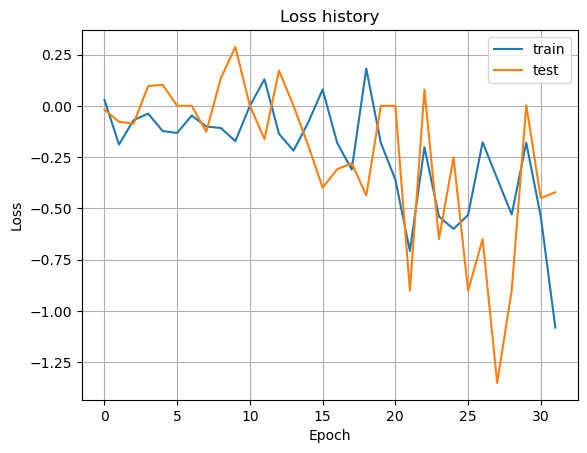

In [46]:
my_train(gru_model)

Epoch [1/32]. Step [88/88]. Loss: 0.048. Recall: 0.804. Acc: 0.633. Test loss: -0.034. Test acc: 0.771. Test recall 1.000
Epoch [2/32]. Step [88/88]. Loss: -0.028. Recall: 1.000. Acc: 0.774. Test loss: -0.223. Test acc: 0.771. Test recall 1.000
Epoch [3/32]. Step [88/88]. Loss: -0.137. Recall: 1.000. Acc: 0.774. Test loss: 0.001. Test acc: 0.771. Test recall 1.000
Epoch [4/32]. Step [88/88]. Loss: -0.150. Recall: 1.000. Acc: 0.774. Test loss: -0.283. Test acc: 0.771. Test recall 1.000
Epoch [5/32]. Step [88/88]. Loss: 0.041. Recall: 1.000. Acc: 0.774. Test loss: 0.103. Test acc: 0.771. Test recall 1.000
Epoch [6/32]. Step [88/88]. Loss: 0.000. Recall: 1.000. Acc: 0.774. Test loss: -0.331. Test acc: 0.771. Test recall 1.000
Epoch [7/32]. Step [88/88]. Loss: -0.095. Recall: 1.000. Acc: 0.774. Test loss: -0.119. Test acc: 0.771. Test recall 1.000
Epoch [8/32]. Step [88/88]. Loss: -0.153. Recall: 1.000. Acc: 0.774. Test loss: -0.128. Test acc: 0.771. Test recall 1.000
Epoch [9/32]. Step [8

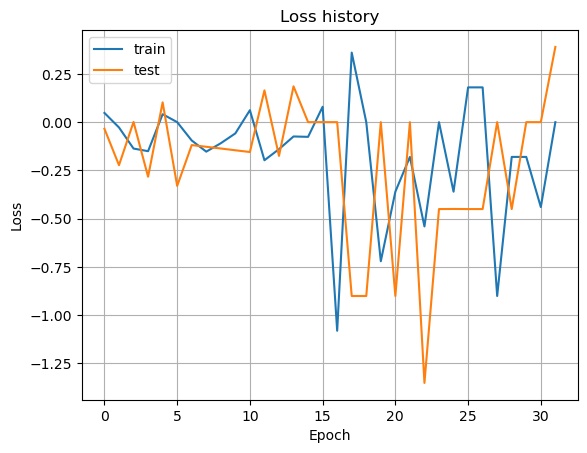

In [47]:
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0001)
my_train(lstm_model)

In [52]:
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import accuracy_score
ACCtrain=[]
ACCtest=[]

LogiRE = LogisticRegression()
LogiRE.fit(X_train, Y_train)
predTrain =LogiRE.predict(X_train)
accuracyTrain = accuracy_score(predTrain, Y_train)
print('Score of accuracy for the training data: ', accuracyTrain)

predTest = LogiRE.predict(X_test)
accuracyTest = accuracy_score(predTest, Y_test)
print('Accuracy score for the test data : ', accuracyTest)
ACCtrain.append(round(accuracyTrain, 3))
ACCtest.append(round(accuracyTest, 3))

Score of accuracy for the training data:  0.7732938749887902
Accuracy score for the test data :  0.7705755782678859


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [55]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, predTest))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       218
           1       0.77      1.00      0.87      2865
           2       0.00      0.00      0.00       635

    accuracy                           0.77      3718
   macro avg       0.26      0.33      0.29      3718
weighted avg       0.59      0.77      0.67      3718



C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
submission = pd.DataFrame({'id':test_df['id'],'label':LogiRE.predict(X_train)})
submission.to_csv("sample_upload.csv",index=False)

ValueError: X has 28576 features, but LogisticRegression is expecting 20 features as input.